# Wandrer scraper

This code utilizes my account at [wandrer.earth] to identify regions where I have traveled in order top optimize game points for distance traveled within specific regions. The code is intended to do the following:


1. Differentiate between foot, bike, or total achievement
2. Identify regions where I have the least distance to a milestone (25%, 50%, 75%, 90%, or 99% completion)
3. Report a map with locations on transit closest to the given distance
    1. Show a map with a 2.5k and 5k diameter around my common hubs   
        1. Kids' activities
        2. Transit stops
    2. Overlay map with the key areas closest to completion

In [1]:
#imports used:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from collections import Counter
import json
import re
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

#not yet used, but imported:
from urllib.request import urlopen
import mechanicalsoup
import time
from requests.auth import HTTPBasicAuth

`payload.py` contains my login (secret), password (secret), login_url (https://wandrer.earth/signin), and dashboard_url (secret)

The code below opens and reads my payload file and initiates a session in my account at wandrer.earth

In [2]:
#my specific credentials for login
with open('payload.py', 'r') as file:
    exec(file.read())

In [3]:
#create a specific session
with requests.session() as s: 
    
    #use GET command to find the authenticity token within the login url
    req = s.get(login_url).text 
    html = BeautifulSoup(req,"html.parser") 
    token = html.find("input", {"name": "authenticity_token"}).attrs["value"] 

    #use my specific authenticity token (which is scraped from the site) plus credentials (from the payload file) to access my account
    payload = { 
        "authenticity_token": token, 
        'athlete[email]': login, 
        'athlete[password]': password, 
    }
    
    #response following posting my data to the location above
    res = s.post(login_url, data=payload) 

#report outcome of login activity
if res.ok or res.status_code == 302:
    redirected_url = res.url
    print("Login successful", res.status_code, redirected_url)
else:
    print("Login failed")

Login successful 200 https://wandrer.earth/dashboard


A `200` code indicates successful login to my dashboard. I next scrape the information from the dashboard to find regions, distances, and percent completion

In [4]:
#retrieve the contents of the dashboard site
r = s.get(dashboard_url) 
soup = BeautifulSoup (r.content, "html.parser")
print(dashboard_url, soup)

https://wandrer.earth/athletes/77230/metro-vancouver-regional-district-british-columbia-canada#7.44/49.287/-123.061 <!DOCTYPE html>

<html lang="en">
<head>
<title>Wandrer - Amy Jancewicz (Metro Vancouver Regional District)</title>
<script crossorigin="anonymous" integrity="sha384-wcrNB9xu3AFa0lJwycNeQBrNOYLOZoE4TQotc9kSM8HTuTIB2WEucsI+ZSzuZQCg" src="https://unpkg.com/mapbox-gl@1.13.0/dist/mapbox-gl.js"></script>
<script crossorigin="anonymous" integrity="sha256-hfmVcDB4v86G5tVgzUJ60031uvFWF+38pqVjkCxTkNs=" src="https://cdnjs.cloudflare.com/ajax/libs/intro.js/2.7.0/intro.min.js"></script>
<script crossorigin="anonymous" integrity="sha256-PquXqTvvZ0ST37z1IS11qpxcI5KBF+bJLGqBBY+loW0=" src="https://cdnjs.cloudflare.com/ajax/libs/vanilla-lazyload/8.7.1/lazyload.min.js"></script>
<script crossorigin="anonymous" integrity="sha384-UsmkNeZeX/gA3VvLoHVqR9S5REtaxYj3Wnxuj66ksCAeeLfZxfbmUjnrare7zAIY" src="https://unpkg.com/pbf@3.0.5/dist/pbf.js"></script>
<script crossorigin="anonymous" integrity=

* All code above is used to locate, open, and read the wandrer.earth data. This must be executed properly before moving forward.
* `soup` is now a variable containing the html content of the site `dashboard_url`

Next, I make lists to hold the region gb code, which allows for opening the specific achievement site and retrieving foot, bike, and total distance numbers. Additionally, lists will hold region name and the gps coordinates for their location.

In [5]:
# Initialize lists to store data
region_gb_list = []
region_name_list = []
region_gps_list = []
region_progress_list = []

# Set counters to track missing values
no_name = 0
no_gb = 0
no_gps = 0
no_progress = 0

# Find all elements with the class "achievement_row"
achievement_rows = soup.find_all(class_="achievement_row")

#iterate through each achievement row
for achievement_row in achievement_rows:
    #extract location text
    #if section has name, use that, then check missing name, otherwise 'N/A'
    
    present_name_element = achievement_row.select_one('.achievement_name')
    missing_name_element = achievement_row.select_one('.missing_achievement_name')

    if present_name_element:
        achievement_name = present_name_element.text
        
    elif missing_name_element:
        achievement_name = missing_name_element.text
    
    else:
        achievement_name = 'N/A'
        no_name = no_name + 1
    
    region_name_list.append(achievement_name)
    
    # Extract "gb ID" value
    data_gb_value = achievement_row.select_one('.geom_toggle')['data-gb'] if achievement_row.select_one('.geom_toggle') else "N/A"
    if data_gb_value == "N/A":
        no_gb += 1
    region_gb_list.append(data_gb_value)

    # Extract coordinates
    coordinates = eval(achievement_row.select_one('.geom_toggle')['data-diagonal'])['coordinates'] if achievement_row.select_one('.geom_toggle') else "N/A"
    if coordinates == "N/A":
        no_gps += 1
    region_gps_list.append(coordinates)
    
    # Extract progress
    progress_element = achievement_row.select_one('.progress-bar')
    progress = progress_element['style'].split(':')[1].strip('%;') if progress_element else "N/A"
    if progress == "N/A":
        no_progress += 1
    region_progress_list.append(progress)

# Show the number of missing values vs. found values
print(f"GB IDs\n Missing: {no_gb}, Present: {len(region_gb_list) - no_gb}")
print(f"Names\n Missing: {no_name}, Present: {len(region_name_list) - no_name}")
print(f"Coordinates\n Missing: {no_gps}, Present: {len(region_gps_list) - no_gps}")
print(f"Foot Progress\n Missing: {no_progress}, Present: {len(region_progress_list) - no_progress}")


GB IDs
 Missing: 15, Present: 162
Names
 Missing: 2, Present: 175
Coordinates
 Missing: 15, Present: 162
Foot Progress
 Missing: 15, Present: 162


There are 173 valid Name calls, but only 162 valid Regions. The name calls are likely non-location achievements, which will be dropped in the subsequent df.

Next, I'll scrape sub-sites for each GB value to find the total distance available by plugging the GB value into a base url for the geometry badges, and retrieving the result. This is done by using `region_gb_list` to create a new list, `num_region_gb_list`, containing only regions that are floats (have geometry for location).

In [6]:
#define a list for only numeric gb entries
num_region_gb_list = [x for x in region_gb_list if 'N/A' not in x]

The code in the next cell searches through each item in the `num_region_gb_list`, plugs it into the base url, gets the soup and parses, looking for that region's distance on foot, bike, and total. Because some regions only have total distance, I account for that in the total distance search.

In [7]:
#prepare lists for data on distances:
#(by including the code in this block, it will prevent overloading redundant data in these lists if the code is re-run)
region_foot_distance_list = []
region_bike_distance_list = []
region_total_distance_list = []

#look for the summary pages of each of the regions represented by the gb codes, by scraping their individual URLs.
for i in num_region_gb_list:
    gb_url = ('https://wandrer.earth/geometry_badges/'+i)
    r = s.get(gb_url) 
    sub_soup = BeautifulSoup(r.content, "html.parser")

#retrieve the total distance on bike, foot, and total.
#some gb areas do not have breakdown by bike and foot, assume the total is equal to the distance on bike or foot.

    #foot distance
    foot_span = sub_soup.find('span', string=lambda s: 'foot' in s)

    #bike distance
    bike_span = sub_soup.find('span', string=lambda s: 'bike' in s)
    
    #total distance
        #this is an interesting case, because when bike and run distances are not presented, the string is different.
        #use an if statement to look for cases with all 3 listed, and else find the single total value.
    if sub_soup.find('span', string=lambda s: 'total length' in s):
        total_span = sub_soup.find('span', string=lambda s: 'total length' in s)
    else: total_span = sub_soup.find('span', string=lambda s: 'km. Worth' in s)

    #convert foot, bike, or total found in html to TEXT, strip excess characters
    text = lambda f: f.get_text().strip().replace(',', '') if f else 'NA'
    
    #Append the distances to new lists
    region_foot_distance_list.append(text(foot_span))
    region_bike_distance_list.append(text(bike_span))
    region_total_distance_list.append(text(total_span))

    print(f'{gb_url} \n    {text(foot_span)},\n    {text(bike_span)},\n    {text(total_span)}')

https://wandrer.earth/geometry_badges/324902 
    59.7 km on foot. Worth 74.2 total points.,
    58.1 km on bike. Worth 72.3 total points.,
    61.4 km total length. Worth 76.4 total points.
https://wandrer.earth/geometry_badges/143055 
    128.5 km on foot. Worth 159.7 total points.,
    107.6 km on bike. Worth 133.8 total points.,
    128.5 km total length. Worth 159.7 total points.
https://wandrer.earth/geometry_badges/341677 
    25.4 km on foot. Worth 31.6 total points.,
    24.3 km on bike. Worth 30.2 total points.,
    25.5 km total length. Worth 31.7 total points.
https://wandrer.earth/geometry_badges/343778 
    NA,
    NA,
    0.5 km. Worth 0.6 total points.
https://wandrer.earth/geometry_badges/324852 
    58.4 km on foot. Worth 72.6 total points.,
    55.3 km on bike. Worth 68.7 total points.,
    58.5 km total length. Worth 72.6 total points.
https://wandrer.earth/geometry_badges/350749 
    21.9 km on foot. Worth 27.2 total points.,
    20.6 km on bike. Worth 25.6 total p

https://wandrer.earth/geometry_badges/350178 
    56.3 km on foot. Worth 70.0 total points.,
    53.0 km on bike. Worth 65.8 total points.,
    56.3 km total length. Worth 70.0 total points.
https://wandrer.earth/geometry_badges/324869 
    54.8 km on foot. Worth 68.1 total points.,
    43.9 km on bike. Worth 54.6 total points.,
    55.0 km total length. Worth 68.4 total points.
https://wandrer.earth/geometry_badges/324887 
    21.5 km on foot. Worth 26.7 total points.,
    22.3 km on bike. Worth 27.8 total points.,
    22.6 km total length. Worth 28.1 total points.
https://wandrer.earth/geometry_badges/324870 
    76.4 km on foot. Worth 95.0 total points.,
    75.6 km on bike. Worth 94.0 total points.,
    77.2 km total length. Worth 95.9 total points.
https://wandrer.earth/geometry_badges/350607 
    17.5 km on foot. Worth 21.8 total points.,
    16.7 km on bike. Worth 20.8 total points.,
    17.7 km total length. Worth 22.0 total points.
https://wandrer.earth/geometry_badges/324824 

https://wandrer.earth/geometry_badges/324899 
    59.6 km on foot. Worth 74.1 total points.,
    55.0 km on bike. Worth 68.4 total points.,
    59.7 km total length. Worth 74.2 total points.
https://wandrer.earth/geometry_badges/324860 
    NA,
    NA,
    3.4 km. Worth 4.3 total points.
https://wandrer.earth/geometry_badges/142986 
    112.2 km on foot. Worth 139.4 total points.,
    106.7 km on bike. Worth 132.6 total points.,
    112.2 km total length. Worth 139.4 total points.
https://wandrer.earth/geometry_badges/143033 
    244.2 km on foot. Worth 303.5 total points.,
    230.6 km on bike. Worth 286.6 total points.,
    250.7 km total length. Worth 311.6 total points.
https://wandrer.earth/geometry_badges/324894 
    522.5 km on foot. Worth 649.3 total points.,
    489.8 km on bike. Worth 608.8 total points.,
    525.3 km total length. Worth 652.8 total points.
https://wandrer.earth/geometry_badges/324889 
    286.2 km on foot. Worth 355.7 total points.,
    273.4 km on bike. Wor

https://wandrer.earth/geometry_badges/350735 
    36.4 km on foot. Worth 45.2 total points.,
    35.1 km on bike. Worth 43.6 total points.,
    36.4 km total length. Worth 45.3 total points.
https://wandrer.earth/geometry_badges/357617 
    1636.8 km on foot. Worth 2034.1 total points.,
    1625.7 km on bike. Worth 2020.3 total points.,
    1676.2 km total length. Worth 2083.1 total points.
https://wandrer.earth/geometry_badges/324861 
    66.0 km on foot. Worth 82.0 total points.,
    60.1 km on bike. Worth 74.7 total points.,
    66.3 km total length. Worth 82.3 total points.
https://wandrer.earth/geometry_badges/143051 
    1225.3 km on foot. Worth 1522.7 total points.,
    1161.0 km on bike. Worth 1442.8 total points.,
    1240.2 km total length. Worth 1541.3 total points.
https://wandrer.earth/geometry_badges/324888 
    133.5 km on foot. Worth 165.9 total points.,
    123.9 km on bike. Worth 154.0 total points.,
    133.9 km total length. Worth 166.5 total points.
https://wandrer

---

### Checkpoint 1

* I've retrieved key information about achievements from the dashboard!
* I've also retrieved my foot progress percentages!

I want to make a dataframe from this information, but need the shape to match for the rows. I will check the length of each list I want to include to determine their suitability to combine into a df.

In [8]:
region_lists = [region_gb_list, region_name_list, region_gps_list, region_foot_distance_list, region_bike_distance_list, region_total_distance_list, region_progress_list]
list_names = ["region_gb_list", "region_name_list", "region_gps_list", "region_foot_distance_list", "region_bike_distance_list", "region_total_distance_list", "region_progress_list"]

for name, region in zip(list_names, region_lists):
    print(f'{len(region)} :*: {name}')

177 :*: region_gb_list
177 :*: region_name_list
177 :*: region_gps_list
162 :*: region_foot_distance_list
162 :*: region_bike_distance_list
162 :*: region_total_distance_list
177 :*: region_progress_list


Regions number 175 while distances measure 162. I will inspect the data to confirm the additional 13 rows come from time achievements rather than geographic achievements. First, the region information will be combined into a preliminary df.

In [9]:
data = {'GB code': region_gb_list, 'Locations': region_name_list, 'Coordinates': region_gps_list, 'Foot Progress (%)': region_progress_list}
df = pd.DataFrame(data)
df.sample(20)

,GB code,Locations,Coordinates,Foot Progress (%)
13,324898,Brookswood-Fernridge,"[[-122.68063, 49.03107], [-122.63017, 49.08955]]",0.0%; padding-top
139,331628,Tsawwassen First Nation,"[[-123.14057, 49.00224], [-123.06684, 49.05833]]",0.0%; padding-top
148,324876,West End,"[[-122.95205, 49.19932], [-122.93055, 49.21347]]",2.0%; padding-top
134,350735,Sussex-Nelson,"[[-123.01258, 49.20675], [-122.9884, 49.22195]]",44.6%; padding-top
135,357617,The Great Trail | Trans Canada Trail (British ...,"[[-124.05682, 48.40423], [-114.86964, 50.58559]]",2.5%; padding-top
32,324875,Connaught Heights,"[[-122.96008, 49.19698], [-122.94484, 49.20583]]",9.9%; padding-top
3,343778,Apodaca Provincial Park,"[[-123.34106, 49.35268], [-123.3355, 49.35582]]",0.0%; padding-top
120,350815,Slhá7an̓ / Mission 1,"[[-123.09177, 49.31002], [-123.08172, 49.31914]]",60.4%; padding-top
167,N/A,"March, 2023",N/A,N/A
64,340664,Hudson's Bay Company Farm,"[[-122.65395, 49.10717], [-122.59521, 49.14666]]",0.0%; padding-top


In [10]:
time_achievements = df[df['GB code'] == 'N/A']
time_achievements

,GB code,Locations,Coordinates,Foot Progress (%)
162,N/A,N/A,N/A,N/A
163,N/A,N/A,N/A,N/A
164,N/A,2023,N/A,N/A
165,N/A,"January, 2023",N/A,N/A
166,N/A,"February, 2023",N/A,N/A
167,N/A,"March, 2023",N/A,N/A
168,N/A,"April, 2023",N/A,N/A
169,N/A,"May, 2023",N/A,N/A
170,N/A,"June, 2023 (Metro Vancouver Parks)",N/A,N/A
171,N/A,"June, 2023",N/A,N/A


I confirmed that df contains the month achievements, so I will drop these rows and then merge in the gb-distances.

In [11]:
#drop the time achievement rows
df.drop(df[df['GB code'] == 'N/A'].index, inplace=True)
df.shape

(162, 4)

Now the shape of the df matches that of the distance lists, which can be merged to a comprehensive df

In [12]:
#merge the distance data into the preliminary df
df['Foot'] = region_foot_distance_list
df['Bike'] = region_bike_distance_list
df['Total'] = region_total_distance_list
df.shape, df.dtypes

((162, 7),
 GB code              object
 Locations            object
 Coordinates          object
 Foot Progress (%)    object
 Foot                 object
 Bike                 object
 Total                object
 dtype: object)

In [13]:
#inspect the combined df
df.head()

,GB code,Locations,Coordinates,Foot Progress (%),Foot,Bike,Total
0,324902,Aldergrove,"[[-122.50378, 49.04568], [-122.45964, 49.0677]]",0.0%; padding-top,59.7 km on foot. Worth 74.2 total points.,58.1 km on bike. Worth 72.3 total points.,61.4 km total length. Worth 76.4 total points.
1,143055,Anmore,"[[-122.89249, 49.29937], [-122.8225, 49.38255]]",0.0%; padding-top,128.5 km on foot. Worth 159.7 total points.,107.6 km on bike. Worth 133.8 total points.,128.5 km total length. Worth 159.7 total points.
2,341677,Annacis Island,"[[-122.98568, 49.15893], [-122.91786, 49.19395]]",0.0%; padding-top,25.4 km on foot. Worth 31.6 total points.,24.3 km on bike. Worth 30.2 total points.,25.5 km total length. Worth 31.7 total points.
3,343778,Apodaca Provincial Park,"[[-123.34106, 49.35268], [-123.3355, 49.35582]]",0.0%; padding-top,NA,NA,0.5 km. Worth 0.6 total points.
4,324852,Arbutus-Ridge,"[[-123.17826, 49.23459], [-123.14696, 49.25781]]",11.3%; padding-top,58.4 km on foot. Worth 72.6 total points.,55.3 km on bike. Worth 68.7 total points.,58.5 km total length. Worth 72.6 total points.


The dataframe has been successfully created, the desired columns are present, and the information appears correct based on manual inspection of my account info online.

The data is all object type. The following updates are needed:

Column | Change needed
-|-
<b>GB code</b> | change to `int` dtype
<b>Foot Progress</b> | 1. extract number, 2. change to `float` dtype
<b>Locations</b> | none
<b>Coordinates</b> | 1. change to series dtype, 2 calculate midpoint, 3. change to `float` dtype
<b>Foot</b></b> | split to new columns: distance, points. Trim text and change to `float` dtype
<b>Bike</b> | split to new columns: distance, points. Trim text and change to `float` dtype
<b>Total distance</b> |split to new columns: distance, points. Trim text and change to `float` dtype


In [14]:
#update the GB code to float
df['GB code'] = df['GB code'].astype('float64')
df.dtypes

GB code              float64
Locations             object
Coordinates           object
Foot Progress (%)     object
Foot                  object
Bike                  object
Total                 object
dtype: object

In [15]:
df.shape

(162, 7)

Because the coordinates are composed of a list of lists, I will split into coordinate1 and coordinate2, and then split each of these into longitude and latitude, resaving as 4 new lists and dropping the coordinates and c1, c2 lists used for the transformation.

In [16]:
#create the c1 and c2 for the two coordinate pairs
df[['c1', 'c2']] = pd.DataFrame(df['Coordinates'].tolist(), columns=['c1', 'c2'])
df[['c1', 'c2']]

,c1,c2
0,"[-122.50378, 49.04568]","[-122.45964, 49.0677]"
1,"[-122.89249, 49.29937]","[-122.8225, 49.38255]"
2,"[-122.98568, 49.15893]","[-122.91786, 49.19395]"
3,"[-123.34106, 49.35268]","[-123.3355, 49.35582]"
4,"[-123.17826, 49.23459]","[-123.14696, 49.25781]"
...,...,...
157,"[-122.67989, 49.1115]","[-122.64702, 49.12627]"
158,"[-122.98898, 49.21505]","[-122.97194, 49.23095]"
159,"[-123.1487, 49.31265]","[-123.12017, 49.32885]"
160,"[-122.80709, 49.22904]","[-122.78659, 49.2521]"


In [17]:
#split c1 and c2 into longitude and latitude, then compile into the df, dropping the coordinates, c1, and c2 columns used for their generation
df[['lon1', 'lat1']] = pd.DataFrame(df['c1'].tolist(), columns=['lon1', 'lat1'])
df[['lon2', 'lat2']] = pd.DataFrame(df['c2'].tolist(), columns=['lon2', 'lat2'])

df = df.drop(['Coordinates', 'c1', 'c2'], axis=1)
df

,GB code,Locations,Foot Progress (%),Foot,Bike,Total,lon1,lat1,lon2,lat2
0,324902.0,Aldergrove,0.0%; padding-top,59.7 km on foot. Worth 74.2 total points.,58.1 km on bike. Worth 72.3 total points.,61.4 km total length. Worth 76.4 total points.,-122.50378,49.04568,-122.45964,49.06770
1,143055.0,Anmore,0.0%; padding-top,128.5 km on foot. Worth 159.7 total points.,107.6 km on bike. Worth 133.8 total points.,128.5 km total length. Worth 159.7 total points.,-122.89249,49.29937,-122.82250,49.38255
2,341677.0,Annacis Island,0.0%; padding-top,25.4 km on foot. Worth 31.6 total points.,24.3 km on bike. Worth 30.2 total points.,25.5 km total length. Worth 31.7 total points.,-122.98568,49.15893,-122.91786,49.19395
3,343778.0,Apodaca Provincial Park,0.0%; padding-top,NA,NA,0.5 km. Worth 0.6 total points.,-123.34106,49.35268,-123.33550,49.35582
4,324852.0,Arbutus-Ridge,11.3%; padding-top,58.4 km on foot. Worth 72.6 total points.,55.3 km on bike. Worth 68.7 total points.,58.5 km total length. Worth 72.6 total points.,-123.17826,49.23459,-123.14696,49.25781
...,...,...,...,...,...,...,...,...,...,...
157,343545.0,Willowbrook,0.0%; padding-top,NA,NA,20.7 km. Worth 25.7 total points.,-122.67989,49.11150,-122.64702,49.12627
158,350742.0,Windsor,14.8%; padding-top,22.5 km on foot. Worth 28.0 total points.,21.9 km on bike. Worth 27.2 total points.,22.5 km total length. Worth 28.0 total points.,-122.98898,49.21505,-122.97194,49.23095
159,350816.0,X̱wemelch'stn / Capilano 5,8.8%; padding-top,24.8 km on foot. Worth 30.9 total points.,23.4 km on bike. Worth 29.1 total points.,26.0 km total length. Worth 32.4 total points.,-123.14870,49.31265,-123.12017,49.32885
160,350774.0,kʷikʷəƛ̓əm / Kwikwetlem First Nation,0.0%; padding-top,NA,NA,0.9 km. Worth 1.2 total points.,-122.80709,49.22904,-122.78659,49.25210


In [18]:
#check datatypes of df column values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GB code            162 non-null    float64
 1   Locations          162 non-null    object 
 2   Foot Progress (%)  162 non-null    object 
 3   Foot               162 non-null    object 
 4   Bike               162 non-null    object 
 5   Total              162 non-null    object 
 6   lon1               162 non-null    float64
 7   lat1               162 non-null    float64
 8   lon2               162 non-null    float64
 9   lat2               162 non-null    float64
dtypes: float64(5), object(5)
memory usage: 12.8+ KB


In [19]:
#since 'GB code' is float64 dtype, I can count nulls to ensure these were not carried fron the original scrape of date progress awards
df['GB code'].isnull().sum()

0

---

### Checkpoint 2

* `df` contains 9 columns, containing key information on GB code, location, and distances possible
* 5 columns are float while 4 are object dtype
* I need to:
    * extract the distance possible from the text, and convert to float for each max distance column
    * scrape [wandrer.earth] for percent completed in each of foot, bike, total (for official, rather than calculated value)
    * scrape [wandrer.earth] for distance completed in each of foot, bike, total.

In [20]:
# retrieve distance values, drop extra text
foot_bike_total = df[['Foot', 'Bike', 'Total']]  # Selecting distance columns

for column in foot_bike_total.columns:
    new_distance_values = []  # store distance values
    new_worth_values = []  # store worth 
    for region_text in foot_bike_total[column]:
        if pd.notnull(region_text):  # Check for non-null values
            # Use regular expression to find the distance and worth
            dist_match = re.search(r'(\d+\.\d+)\s*km', str(region_text))
            worth_match = re.search(r'(\d+\.\d+)\s*total', str(region_text))

            if dist_match:  #assume all dist match will have worth match
                distance_value = dist_match.group(1)
                worth_value = worth_match.group(1)
                # append found distance to a new list for distance value
                new_distance_values.append(distance_value)
                # append found worth to a new list for worth value
                new_worth_values.append(worth_value)
            else:
                # If no distance found, list as N/A
                new_distance_values.append("N/A")
                new_worth_values.append("N/A")
        else:
            # For null values, list as N/A
            new_distance_values.append("N/A")
            new_worth_values.append("N/A")

    # Update the DataFrame column with modified values
    df[column + " Distance (km)"] = new_distance_values
    df[column + " Points"] = new_worth_values

# Print the updated DataFrame
df.head()

,GB code,Locations,Foot Progress (%),Foot,Bike,Total,lon1,lat1,lon2,lat2,Foot Distance (km),Foot Points,Bike Distance (km),Bike Points,Total Distance (km),Total Points
0,324902.0,Aldergrove,0.0%; padding-top,59.7 km on foot. Worth 74.2 total points.,58.1 km on bike. Worth 72.3 total points.,61.4 km total length. Worth 76.4 total points.,-122.50378,49.04568,-122.45964,49.06770,59.7,74.2,58.1,72.3,61.4,76.4
1,143055.0,Anmore,0.0%; padding-top,128.5 km on foot. Worth 159.7 total points.,107.6 km on bike. Worth 133.8 total points.,128.5 km total length. Worth 159.7 total points.,-122.89249,49.29937,-122.82250,49.38255,128.5,159.7,107.6,133.8,128.5,159.7
2,341677.0,Annacis Island,0.0%; padding-top,25.4 km on foot. Worth 31.6 total points.,24.3 km on bike. Worth 30.2 total points.,25.5 km total length. Worth 31.7 total points.,-122.98568,49.15893,-122.91786,49.19395,25.4,31.6,24.3,30.2,25.5,31.7
3,343778.0,Apodaca Provincial Park,0.0%; padding-top,NA,NA,0.5 km. Worth 0.6 total points.,-123.34106,49.35268,-123.33550,49.35582,N/A,N/A,N/A,N/A,0.5,0.6
4,324852.0,Arbutus-Ridge,11.3%; padding-top,58.4 km on foot. Worth 72.6 total points.,55.3 km on bike. Worth 68.7 total points.,58.5 km total length. Worth 72.6 total points.,-123.17826,49.23459,-123.14696,49.25781,58.4,72.6,55.3,68.7,58.5,72.6


In [21]:
# retrieve progress values, drop extra text 
new_percent_values = []  # store percent values

for i in df['Foot Progress (%)']:   # Selecting progress column
    if pd.notnull(i):  # Check for non-null values
        # Use regular expression to find the distance and worth
        match = re.search(r'(\d+\.\d+)\s*%', str(i))
        
        if match:
            # make the value a float
            percent = float(match.group(1))
            # append found percent to a new list for percent value
            new_percent_values.append(percent)
        else:
            new_percent_values.append("N/A") # account for null values
       
    else:
        # For null values, list as N/A
        new_percent_values.append("N/A")

# Update the DataFrame column with modified values
df['Foot Progress (%)'] = new_percent_values

# Print the updated DataFrame
df.head()

,GB code,Locations,Foot Progress (%),Foot,Bike,Total,lon1,lat1,lon2,lat2,Foot Distance (km),Foot Points,Bike Distance (km),Bike Points,Total Distance (km),Total Points
0,324902.0,Aldergrove,0.0,59.7 km on foot. Worth 74.2 total points.,58.1 km on bike. Worth 72.3 total points.,61.4 km total length. Worth 76.4 total points.,-122.50378,49.04568,-122.45964,49.06770,59.7,74.2,58.1,72.3,61.4,76.4
1,143055.0,Anmore,0.0,128.5 km on foot. Worth 159.7 total points.,107.6 km on bike. Worth 133.8 total points.,128.5 km total length. Worth 159.7 total points.,-122.89249,49.29937,-122.82250,49.38255,128.5,159.7,107.6,133.8,128.5,159.7
2,341677.0,Annacis Island,0.0,25.4 km on foot. Worth 31.6 total points.,24.3 km on bike. Worth 30.2 total points.,25.5 km total length. Worth 31.7 total points.,-122.98568,49.15893,-122.91786,49.19395,25.4,31.6,24.3,30.2,25.5,31.7
3,343778.0,Apodaca Provincial Park,0.0,NA,NA,0.5 km. Worth 0.6 total points.,-123.34106,49.35268,-123.33550,49.35582,N/A,N/A,N/A,N/A,0.5,0.6
4,324852.0,Arbutus-Ridge,11.3,58.4 km on foot. Worth 72.6 total points.,55.3 km on bike. Worth 68.7 total points.,58.5 km total length. Worth 72.6 total points.,-123.17826,49.23459,-123.14696,49.25781,58.4,72.6,55.3,68.7,58.5,72.6


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GB code              162 non-null    float64
 1   Locations            162 non-null    object 
 2   Foot Progress (%)    162 non-null    float64
 3   Foot                 162 non-null    object 
 4   Bike                 162 non-null    object 
 5   Total                162 non-null    object 
 6   lon1                 162 non-null    float64
 7   lat1                 162 non-null    float64
 8   lon2                 162 non-null    float64
 9   lat2                 162 non-null    float64
 10  Foot Distance (km)   162 non-null    object 
 11  Foot Points          162 non-null    object 
 12  Bike Distance (km)   162 non-null    object 
 13  Bike Points          162 non-null    object 
 14  Total Distance (km)  162 non-null    object 
 15  Total Points         162 non-null    obj

Drop the Foot Progress (%), Foot, Bike, Total columns, convert distance and worth columns to float dtype.

In [23]:
#drop the time achievement rows
df.drop(['Foot', 'Bike', 'Total'], axis=1, inplace=True)
print(df.shape)
df.info()

(162, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GB code              162 non-null    float64
 1   Locations            162 non-null    object 
 2   Foot Progress (%)    162 non-null    float64
 3   lon1                 162 non-null    float64
 4   lat1                 162 non-null    float64
 5   lon2                 162 non-null    float64
 6   lat2                 162 non-null    float64
 7   Foot Distance (km)   162 non-null    object 
 8   Foot Points          162 non-null    object 
 9   Bike Distance (km)   162 non-null    object 
 10  Bike Points          162 non-null    object 
 11  Total Distance (km)  162 non-null    object 
 12  Total Points         162 non-null    object 
dtypes: float64(6), object(7)
memory usage: 16.6+ KB


In [24]:
float_cols = ['Foot Distance (km)', 'Foot Points', 'Bike Distance (km)', 'Bike Points', 'Total Distance (km)', 'Total Points']

for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert the specified columns to float64
df[float_cols] = df[float_cols].astype('float64')

# Check the data types after conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GB code              162 non-null    float64
 1   Locations            162 non-null    object 
 2   Foot Progress (%)    162 non-null    float64
 3   lon1                 162 non-null    float64
 4   lat1                 162 non-null    float64
 5   lon2                 162 non-null    float64
 6   lat2                 162 non-null    float64
 7   Foot Distance (km)   149 non-null    float64
 8   Foot Points          149 non-null    float64
 9   Bike Distance (km)   149 non-null    float64
 10  Bike Points          149 non-null    float64
 11  Total Distance (km)  162 non-null    float64
 12  Total Points         162 non-null    float64
dtypes: float64(12), object(1)
memory usage: 16.6+ KB


---

### Checkpoint 3

* `df` contains 13 columns, containing key information on GB code, location, distances, completed percent, and point value
* all columns except Locations are float dtype
* lat and lon values are seperated.

Next, 

1. IF:
    * distance >75%, find <u>the distance required to complete (>99%) region</u>
    * distance >50%, find <u>the distance required to move to >75%</u>
    * distance >25%, find <u>the distance required to move to >50%</u>
    * distance <25%, find <u>the distance required to move to >25%</u>
2. find the distance of regions that haven't been started (0% complete and would move to 25%)
3. sort by shortest distance to completion for the region
4. calculate center longutide and latitude for the lon1+lon2 and lat1+lat2

In [25]:
inprogress_df = df
inprogress_df

,GB code,Locations,Foot Progress (%),lon1,lat1,lon2,lat2,Foot Distance (km),Foot Points,Bike Distance (km),Bike Points,Total Distance (km),Total Points
0,324902.0,Aldergrove,0.0,-122.50378,49.04568,-122.45964,49.06770,59.7,74.2,58.1,72.3,61.4,76.4
1,143055.0,Anmore,0.0,-122.89249,49.29937,-122.82250,49.38255,128.5,159.7,107.6,133.8,128.5,159.7
2,341677.0,Annacis Island,0.0,-122.98568,49.15893,-122.91786,49.19395,25.4,31.6,24.3,30.2,25.5,31.7
3,343778.0,Apodaca Provincial Park,0.0,-123.34106,49.35268,-123.33550,49.35582,NaN,NaN,NaN,NaN,0.5,0.6
4,324852.0,Arbutus-Ridge,11.3,-123.17826,49.23459,-123.14696,49.25781,58.4,72.6,55.3,68.7,58.5,72.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,343545.0,Willowbrook,0.0,-122.67989,49.11150,-122.64702,49.12627,NaN,NaN,NaN,NaN,20.7,25.7
158,350742.0,Windsor,14.8,-122.98898,49.21505,-122.97194,49.23095,22.5,28.0,21.9,27.2,22.5,28.0
159,350816.0,X̱wemelch'stn / Capilano 5,8.8,-123.14870,49.31265,-123.12017,49.32885,24.8,30.9,23.4,29.1,26.0,32.4
160,350774.0,kʷikʷəƛ̓əm / Kwikwetlem First Nation,0.0,-122.80709,49.22904,-122.78659,49.25210,NaN,NaN,NaN,NaN,0.9,1.2


In [26]:
inprogress_df['Percent to Level'] = 0.0

for index, row in inprogress_df.iterrows():
    progress = row['Foot Progress (%)']
    if progress >= 99.0:
        0
    elif progress >= 90.0:
        inprogress_df.at[index, 'Percent to Level'] = 99.0 - progress
    elif progress >= 75.0:
        inprogress_df.at[index, 'Percent to Level'] = 90.0 - progress
    elif progress >= 50.0:
        inprogress_df.at[index, 'Percent to Level'] = 75.0 - progress
    elif progress >= 25.0:
        inprogress_df.at[index, 'Percent to Level'] = 50.0 - progress
    else:
        inprogress_df.at[index, 'Percent to Level'] = 25.0 - progress
        
inprogress_df.sort_values(by='Percent to Level', ascending=True, inplace=True)
inprogress_df.head()

,GB code,Locations,Foot Progress (%),lon1,lat1,lon2,lat2,Foot Distance (km),Foot Points,Bike Distance (km),Bike Points,Total Distance (km),Total Points,Percent to Level
59,324842.0,Granville Island,99.3,-123.13735,49.26838,-123.13052,49.27319,4.2,5.2,2.9,3.6,4.2,5.2,0.0
108,324847.0,Renfrew-Collingwood,99.3,-123.05888,49.23198,-123.02357,49.26557,133.0,165.3,125.8,156.3,133.5,165.9,0.0
71,324841.0,Kitsilano No. 6,100.0,-123.14621,49.27089,-123.13954,49.27412,0.2,0.2,0.4,0.5,0.5,0.7,0.0
16,350763.0,Burkeville,97.8,-123.15051,49.18482,-123.14265,49.19202,5.5,6.9,5.2,6.5,5.5,6.9,1.2
87,324843.0,Mount Pleasant,88.4,-123.11510,49.25625,-123.07749,49.27305,73.7,91.5,72.5,90.0,78.1,97.1,1.6


In [27]:
# Replace 'N/A' with NaN for numeric comparison
inprogress_df['Foot Distance (km)'] = pd.to_numeric(inprogress_df['Foot Distance (km)'], errors='coerce')

# Create conditions to identify 'N/A' values
condition_na = inprogress_df['Foot Distance (km)'].isnull()

# Calculate 'Distance to Level' based on conditions
inprogress_df['Distance to Level'] = np.where(
    condition_na,
    (inprogress_df['Percent to Level'] / 100) * inprogress_df['Total Distance (km)'],
    (inprogress_df['Percent to Level'] / 100) * inprogress_df['Foot Distance (km)']
)

# Show the modified DataFrame
inprogress_df

,GB code,Locations,Foot Progress (%),lon1,lat1,lon2,lat2,Foot Distance (km),Foot Points,Bike Distance (km),Bike Points,Total Distance (km),Total Points,Percent to Level,Distance to Level
59,324842.0,Granville Island,99.3,-123.13735,49.26838,-123.13052,49.27319,4.2,5.2,2.9,3.6,4.2,5.2,0.0,0.0000
108,324847.0,Renfrew-Collingwood,99.3,-123.05888,49.23198,-123.02357,49.26557,133.0,165.3,125.8,156.3,133.5,165.9,0.0,0.0000
71,324841.0,Kitsilano No. 6,100.0,-123.14621,49.27089,-123.13954,49.27412,0.2,0.2,0.4,0.5,0.5,0.7,0.0,0.0000
16,350763.0,Burkeville,97.8,-123.15051,49.18482,-123.14265,49.19202,5.5,6.9,5.2,6.5,5.5,6.9,1.2,0.0660
87,324843.0,Mount Pleasant,88.4,-123.11510,49.25625,-123.07749,49.27305,73.7,91.5,72.5,90.0,78.1,97.1,1.6,1.1792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,352433.0,Green Timbers Urban Forest,0.0,-122.83436,49.16910,-122.81214,49.18859,31.9,39.7,30.2,37.5,35.1,43.6,25.0,7.9750
56,324881.0,Glenbrooke North,0.0,-122.92770,49.21316,-122.90838,49.22475,NaN,NaN,NaN,NaN,15.0,18.6,25.0,3.7500
55,324864.0,Gilmore,0.0,-123.15884,49.10990,-123.10294,49.13351,23.6,29.4,21.9,27.2,23.7,29.4,25.0,5.9000
160,350774.0,kʷikʷəƛ̓əm / Kwikwetlem First Nation,0.0,-122.80709,49.22904,-122.78659,49.25210,NaN,NaN,NaN,NaN,0.9,1.2,25.0,0.2250


Point maximizer is calculated by dividing the foot points possible by the percent to the next level, which should result in larger values for the point maximizer when there are more points available for less distance.

In [28]:
inprogress_df['point_maximizer'] =  inprogress_df['Foot Points'] / inprogress_df['Percent to Level']
inprogress_df

,GB code,Locations,Foot Progress (%),lon1,lat1,lon2,lat2,Foot Distance (km),Foot Points,Bike Distance (km),Bike Points,Total Distance (km),Total Points,Percent to Level,Distance to Level,point_maximizer
59,324842.0,Granville Island,99.3,-123.13735,49.26838,-123.13052,49.27319,4.2,5.2,2.9,3.6,4.2,5.2,0.0,0.0000,inf
108,324847.0,Renfrew-Collingwood,99.3,-123.05888,49.23198,-123.02357,49.26557,133.0,165.3,125.8,156.3,133.5,165.9,0.0,0.0000,inf
71,324841.0,Kitsilano No. 6,100.0,-123.14621,49.27089,-123.13954,49.27412,0.2,0.2,0.4,0.5,0.5,0.7,0.0,0.0000,inf
16,350763.0,Burkeville,97.8,-123.15051,49.18482,-123.14265,49.19202,5.5,6.9,5.2,6.5,5.5,6.9,1.2,0.0660,5.7500
87,324843.0,Mount Pleasant,88.4,-123.11510,49.25625,-123.07749,49.27305,73.7,91.5,72.5,90.0,78.1,97.1,1.6,1.1792,57.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,352433.0,Green Timbers Urban Forest,0.0,-122.83436,49.16910,-122.81214,49.18859,31.9,39.7,30.2,37.5,35.1,43.6,25.0,7.9750,1.5880
56,324881.0,Glenbrooke North,0.0,-122.92770,49.21316,-122.90838,49.22475,NaN,NaN,NaN,NaN,15.0,18.6,25.0,3.7500,NaN
55,324864.0,Gilmore,0.0,-123.15884,49.10990,-123.10294,49.13351,23.6,29.4,21.9,27.2,23.7,29.4,25.0,5.9000,1.1760
160,350774.0,kʷikʷəƛ̓əm / Kwikwetlem First Nation,0.0,-122.80709,49.22904,-122.78659,49.25210,NaN,NaN,NaN,NaN,0.9,1.2,25.0,0.2250,NaN


In [29]:
#search for initiated regions with leveling opportunities
fastest_wins_df = inprogress_df[(inprogress_df['Foot Progress (%)'] <= 99) & (inprogress_df['Foot Progress (%)'] > 0)]

# Sorting by 'Foot Distance (km)' and 'Distance to Level'

fastest_wins_df = fastest_wins_df.sort_values(by='point_maximizer', ascending=False)

# Rounding 'Distance to Level' and converting it to float with 3 decimal places
fastest_wins_df['Distance to Level'] = round((fastest_wins_df['Distance to Level']).astype(float), 3)
fastest_wins_df = fastest_wins_df[fastest_wins_df['Distance to Level'] < 100]

# Displaying the top 20 rows
fastest_wins_df = fastest_wins_df.head(20)
fastest_wins_df = fastest_wins_df.sort_values(by='Distance to Level', ascending=True)
fastest_wins_df

,GB code,Locations,Foot Progress (%),lon1,lat1,lon2,lat2,Foot Distance (km),Foot Points,Bike Distance (km),Bike Points,Total Distance (km),Total Points,Percent to Level,Distance to Level,point_maximizer
83,350737.0,Maywood,96.8,-123.02368,49.22194,-122.99414,49.23302,40.6,50.5,36.7,45.6,40.9,50.8,2.2,0.893,22.954545
87,324843.0,Mount Pleasant,88.4,-123.11510,49.25625,-123.07749,49.27305,73.7,91.5,72.5,90.0,78.1,97.1,1.6,1.179,57.187500
97,324853.0,Oakridge,45.1,-123.14018,49.21896,-123.10565,49.23435,49.8,61.9,47.7,59.3,50.2,62.4,4.9,2.440,12.632653
70,324837.0,Kitsilano,46.5,-123.18614,49.25716,-123.13882,49.27921,101.1,125.7,97.3,120.9,106.5,132.3,3.5,3.538,35.914286
40,324839.0,Downtown,70.4,-123.13670,49.27053,-123.09946,49.29533,85.6,106.4,83.7,104.0,107.7,133.8,4.6,3.938,23.130435
132,324855.0,Sunset,45.3,-123.10694,49.20480,-123.07703,49.23316,90.2,112.1,89.5,111.2,92.2,114.6,4.7,4.239,23.851064
126,339221.0,Stanley Park National Historic Site,44.3,-123.15965,49.28976,-123.11636,49.31408,77.5,96.3,43.9,54.6,90.7,112.7,5.7,4.418,16.894737
142,324859.0,University of British Columbia,18.8,-123.26221,49.24313,-123.22736,49.27312,71.9,89.4,54.9,68.2,73.5,91.3,6.2,4.458,14.419355
66,324848.0,Kensington-Cedar Cottage,95.4,-123.09061,49.23259,-123.05663,49.26242,127.9,158.9,122.2,151.8,129.9,161.4,3.6,4.604,44.138889
67,324834.0,Kerrisdale,43.7,-123.17911,49.20574,-123.13965,49.23480,74.4,92.5,72.8,90.5,74.5,92.6,6.3,4.687,14.682540


---

### Checkpoint 4

* `fastest_wins_df` shows the top regions for the quickest leveling up, sorted based on maximizing points, but for regions with less than 50km to the leveling event

In [34]:
#find the average lat and lon values, which should represent a point at the middle of the region area
fastest_wins_df['Avg Longitude'] = ((fastest_wins_df['lon1'] + fastest_wins_df['lon2'])/2)
fastest_wins_df['Avg Latitude'] = ((fastest_wins_df['lat1'] + fastest_wins_df['lat2'])/2)
fastest_wins_df['point_maximizer'] = (fastest_wins_df['point_maximizer']/fastest_wins_df['Distance to Level'])
fastest_wins_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 83 to 153
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GB code              20 non-null     float64
 1   Locations            20 non-null     object 
 2   Foot Progress (%)    20 non-null     float64
 3   lon1                 20 non-null     float64
 4   lat1                 20 non-null     float64
 5   lon2                 20 non-null     float64
 6   lat2                 20 non-null     float64
 7   Foot Distance (km)   20 non-null     float64
 8   Foot Points          20 non-null     float64
 9   Bike Distance (km)   20 non-null     float64
 10  Bike Points          20 non-null     float64
 11  Total Distance (km)  20 non-null     float64
 12  Total Points         20 non-null     float64
 13  Percent to Level     20 non-null     float64
 14  Distance to Level    20 non-null     float64
 15  point_maximizer      20 non-null     float64


In [37]:
# Create a GeoDataFrame from latitude and longitude columns
geometry = [Point(xy) for xy in zip(fastest_wins_df['Avg Longitude'], fastest_wins_df['Avg Latitude'])]
gdf = gpd.GeoDataFrame(fastest_wins_df, geometry=geometry, crs='EPSG:4326')
gdf.sort_values(by='point_maximizer', ascending=False, inplace=True)
gdf

,GB code,Locations,Foot Progress (%),lon1,lat1,lon2,lat2,Foot Distance (km),Foot Points,Bike Distance (km),Bike Points,Total Distance (km),Total Points,Percent to Level,Distance to Level,point_maximizer,Avg Longitude,Avg Latitude,geometry
87,324843.0,Mount Pleasant,88.4,-123.11510,49.25625,-123.07749,49.27305,73.7,91.5,72.5,90.0,78.1,97.1,1.6,1.179,48.505089,-123.096295,49.264650,POINT (-123.09629 49.26465)
83,350737.0,Maywood,96.8,-123.02368,49.22194,-122.99414,49.23302,40.6,50.5,36.7,45.6,40.9,50.8,2.2,0.893,25.704978,-123.008910,49.227480,POINT (-123.00891 49.22748)
70,324837.0,Kitsilano,46.5,-123.18614,49.25716,-123.13882,49.27921,101.1,125.7,97.3,120.9,106.5,132.3,3.5,3.538,10.151013,-123.162480,49.268185,POINT (-123.16248 49.26819)
17,143076.0,Burnaby,21.5,-123.02407,49.18019,-122.89260,49.29967,1159.6,1441.1,1057.7,1314.4,1170.8,1455.0,3.5,40.586,10.144948,-122.958335,49.239930,POINT (-122.95834 49.23993)
66,324848.0,Kensington-Cedar Cottage,95.4,-123.09061,49.23259,-123.05663,49.26242,127.9,158.9,122.2,151.8,129.9,161.4,3.6,4.604,9.587074,-123.073620,49.247505,POINT (-123.07362 49.24751)
40,324839.0,Downtown,70.4,-123.13670,49.27053,-123.09946,49.29533,85.6,106.4,83.7,104.0,107.7,133.8,4.6,3.938,5.873650,-123.118080,49.282930,POINT (-123.11808 49.28293)
132,324855.0,Sunset,45.3,-123.10694,49.20480,-123.07703,49.23316,90.2,112.1,89.5,111.2,92.2,114.6,4.7,4.239,5.626578,-123.091985,49.218980,POINT (-123.09198 49.21898)
97,324853.0,Oakridge,45.1,-123.14018,49.21896,-123.10565,49.23435,49.8,61.9,47.7,59.3,50.2,62.4,4.9,2.440,5.177317,-123.122915,49.226655,POINT (-123.12292 49.22666)
63,324846.0,Hastings-Sunrise,70.1,-123.05664,49.26188,-123.02325,49.29391,134.7,167.4,124.6,154.9,137.5,170.9,4.9,6.600,5.176252,-123.039945,49.277895,POINT (-123.03995 49.27790)
77,344156.0,Lower Seymour Conservation Reserve,19.7,-123.02469,49.32963,-122.93739,49.45045,127.8,158.9,103.8,129.0,129.0,160.4,5.3,6.773,4.426566,-122.981040,49.390040,POINT (-122.98104 49.39004)


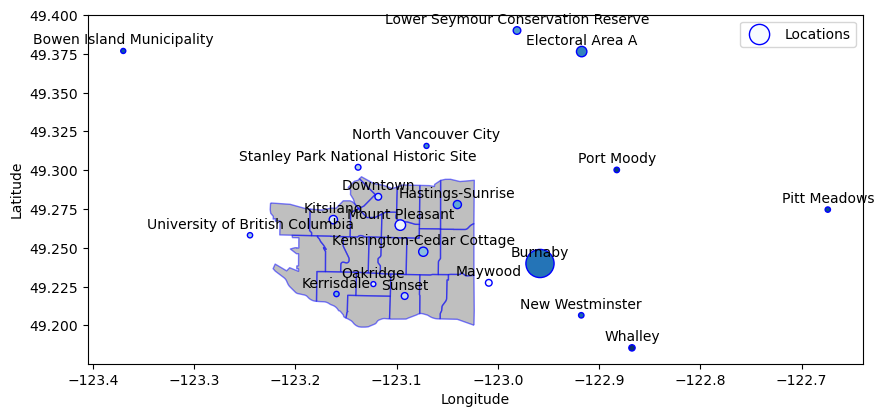

CPU times: user 639 ms, sys: 76.2 ms, total: 715 ms
Wall time: 512 ms


In [32]:
%%time

# Create a GeoDataFrame with Point geometries
gdf['geometry'] = gdf.apply(lambda row: Point(row['Avg Longitude'], row['Avg Latitude']), axis=1)

# Get a basemap of Metro Vancouver
metro_vancouver = gpd.read_file("Vancouver-local-area-boundary.geojson")  # GeoJSON file

# Project both GeoDataFrames to the same CRS (coordinate reference system)
gdf = gdf.to_crs(metro_vancouver.crs)

# Plot the GeoDataFrame with circles representing point_maximizer
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basemap
metro_vancouver.plot(ax=ax, alpha=0.5, color='gray', edgecolor='blue')

# Plot the points with color gradient based on 'Distance to Level' and size based on 'point_maximizer'
# lighter blue means shorter distance to level, and larger circle means higher points
gdf.plot(ax=ax, cmap='Blues', markersize='point_maximizer', label="Locations", legend=True, edgecolor="blue")

# Annotate each point with its 'Locations' name
for idx, row in gdf.iterrows():
    ax.annotate(row['Locations'], (row['Avg Longitude'], row['Avg Latitude']), textcoords="offset points", xytext=(0,5), ha='center')

# Set the axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.legend()
plt.show()

*The plot above shows Vancouver proper and has curcles for the top 20 areas within and nearby. The circle size indicates overall points (larger circle = higher worth) while the color indicates distance, ranging from least required to level (white) to most (dark blue).*